# rl5C-Copy1.ipynb

This notebook contains the fifth step in the 5-step process outlined in November 13th, 2020, in order to produce an actor-critic architecture for pendulum control. 

In step 1 we create a network with N units that takes the activity of 1 unit and transforms it into a bell-shaped representation.  
In step 2 we put 2 of those as the inputs to a (N/2)x(N/2) grid, and visualized.  
In step 3 we took the network from step 2 and connected it to the current SP and SD units in `test3p2` to see if the angle is being tracked.  
In step 4 we will connect a $V$ neuron to the L (RBF) layer, and tweak TD learning so its output starts to reflect the angular error.  
In step 5 the output of $V$ is used to configure a controller. There are three basic options outlined in the November 20th, 2020 entry of the log. This notebook corresponds to the third option. The idea to this model is that you will use the M units to compute a function based on the S input. That function tells you which error to feed the controller.

This is `rl5C` setup for `rga_sig` units in C.

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time
from tools.visualization import plotter

/home/z/projects/draculab/notebook


In [2]:
#===================================================================
#================ CREATE THE NETWORK ===============================
#===================================================================

#np.random.seed(123456) # always the same random values
np.random.seed()   # different random values ever run

# some parameters 
C_type = "rga_sig" # unit type for the C population
des_angs = 0.1 + 0.8*np.random.random(10000) # list of "predicted" angles
pres_interv = 1. # interval that desired values last
par_heter = 0.1 # range of heterogeneity as a fraction of the original value
randz = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz2 = lambda : (1. + par_heter*(np.random.rand(2)-0.5))
randz4 = lambda : (1. + par_heter*(np.random.rand(4)-0.5))
SN = 20 # number of units to represent one angle
No2 = int(np.ceil(SN/2)) # L wiill have (No2)**2 units

# PARAMETER DICTIONARIES
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 10 }
#--------------------------------------------------------------------
# Unit parameters
#--------------------------------------------------------------------
A_params = {'type' : unit_types.logarithmic,
            'init_val' : 0.,
            'tau' : 0.01, # 0.02
            'tau_fast': 0.005,
            'thresh' : 0. }
if C_type == "am_pm":
    init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
    C_unit_type = unit_types.am_pm_oscillator
elif C_type == "am2D":
    init_base = np.array([0.5, 0.5])
    C_unit_type = unit_types.am_oscillator2D
elif C_type == "am_pulse":
    init_base = np.array([0.5, 0.5])
    C_unit_type = unit_types.am_pulse
elif C_type == "am":
    init_base = np.array([0.5, 0.5, 0.5])
    C_unit_type = unit_types.am_oscillator
elif C_type == "rga_sig":
    init_base = np.array([0.5])
    C_unit_type = unit_types.rga_sig
C_params = {'type' : C_unit_type, #unit_types.am_pm_oscillator,
            'integ_meth' : 'euler_maru', #'euler_maru', #'odeint',
            'tau_u' : 0.5 * randz2(), # 0.4*randz2()
            'tau_c' : 0.1 * randz2(), # 0.2
            'tau_t' : 1.,
            'tau_s' : 0.02,
            'init_val' : [r*init_base for r in np.random.random(2)],
            'multidim' : False if C_type=="rga_sig" else True,
            'omega' : 2.*np.pi,
            'F' : 'zero', #'input_sum',
            'A' : 0.5,
            'slope' : 2., # for rga_sig
            'thresh' : 0.3, # for rga_sig
            'integ_amp' : 0., # for rga_sig
            'tau' : 0.02, # for rga_sig
            'tau_fast': 0.01,
            'tau_mid' : 0.05,
            'tau_slow' : 4.,
            'custom_inp_del' : 150,
            'delay' : 0.2,
            'mu' : 0.,
            'sigma' : 0.1 }
# L is the "RBF" layer to represent S_P, S_F
L_params = {'type' : unit_types.sigmoidal,
            'delay' : 102,
            'thresh' : 2.,
            'slope' : 5.,
            'tau' : 0.02,
            'init_val' : 0.5 }
L_geom = {'shape' : 'sheet',
          'arrangement' : 'grid',
          'rows' : No2,
          'columns' : No2,
          'center' : [0., 0.],
          'extent' : [1., 1.] }

M_params = {'type' : unit_types.m_sig,
            'thresh' : 0.5 * randz2(),
            'slope' : 2.5 * randz2(),
            'init_val' : 0.2 * randz2(),
            'delay' : 0.35,
            'n_ports' : 4,
            'tau_fast': 0.01,
            'tau_mid': 0.05,
            'tau_slow' : 8.,
            'tau' : 0.01 * randz2(),
            'coordinates' : [np.array([0.1, 0.8]), np.array([0.4, 0.8])],
            'integ_amp' : 0.,
            'custom_inp_del' : int(np.round(0.3/net_params['min_delay'])) ,
            'des_out_w_abs_sum' : 1.6 }
# plant parameters
P_params = {'type' : plant_models.pendulum, #bouncy_pendulum,
            'length' : 0.5,
            'mass' : 1.,
            'init_angle' : 0.,
            'init_ang_vel' : 0.,
            'g' : 0.,
            'inp_gain' : 2.,
            'mu' : 0.5,
            'bound_angle' : True,
            'pi_visco' : 0.05,
            'tau' : 0.05 } # a made-up time constant for the plant 
                          # see create_freqs_steps below
# Reward unit parameters
R_params = {'type' : unit_types.layer_dist,
            'thresh' : 1., # for large args you want -slope(arg - thresh) to get large
            'slope' : -5.,
            'tau' : 0.01,
            'coordinates' : np.array([.3, .8]),
            'init_val' : 0.1 }
# S1 and S2 provide the distributed angle representations
S_params = {'type' : unit_types.bell_shaped_1D,
            'init_val' : 0.1,
            'tau' : 0.01,
            'center' : list(np.linspace(0., 1., SN)),
            'b' : 50. }
S1_params = S_params.copy() # the input column on the left
S2_params = S_params.copy() # the input row below
S1_params['coordinates'] = [np.array([-.6, -.5 + i/SN]) for i in range(SN)]
S2_params['coordinates'] = [np.array([-.5 + i/SN, -.6]) for i in range(SN)]
# SF, SP
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.,
             'slope' : 1.,
             'init_val' : 0.2,
             'tau' : 0.02 }  # 0.05
SP_params = {'type' : unit_types.source,
             'init_val' : des_angs[0],
             'function' : lambda t: des_angs[int(round(t/pres_interv))] }
# value unit
V_params = {'type' : unit_types.td_sigmo,
            'delay' : 162,
            'init_val' : 0.1,
            'thresh' : 0.5,
            'slope' : 1.,
            'tau' : 0.02,
            'tau_slow' : 300,
            'delta' : 1.,
            'coordinates' : np.array([.8, .8])}
# units to track synaptic weights or other values
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#--------------------------------------------------------------------
# Connection dictionaries
#--------------------------------------------------------------------
# Afferent to motor error selection
A__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
A__M_syn = {'type' : synapse_types.inp_sel, 
            'inp_ports' : 2, # the deault for m_sig targets
            'error_port' : 1, # the default for m_sig targets
            'aff_port' : 2,
            'lrate' : -10., # negative rate for m_sig targets with value inputs
            'w_sum' : 1.5,
            'init_w' : .1 }
# lateral connections in C
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
C__C_syn = {'type' : synapse_types.static,
            'lrate' : 0.1,
            'inp_ports': 1,
            'init_w' : -1. }
# spinal units to plant
C0__P_conn = {'inp_ports' : 0,
             'delays': 0.01 }
C0__P_syn = {'type': synapse_types.static,
            'init_w' : 2. }
C1__P_conn = C0__P_conn
C1__P_syn = {'type': synapse_types.static,
             'init_w' : -2. }
# state to motor errors
L__M_conn = {'rule': 'all_to_all',
            'delay': 0.02 }
L__M_syn = {'type' : synapse_types.diff_rm_hebbian,
            'lrate': .5,
            'inp_ports': 0, # default for m_sig targets
            'l_port' : 3,
            's_port' : 0,
            'v_port' : 1,
            'init_w' : 0.05,
            'w_sum' : 1. }
# expanded state to value unit
L__V_conn = {'rule': 'all_to_all',
            'delay': 0.02 }
L__V_syn = {'type' : synapse_types.td_synapse,
            'lrate': .2,
            'gamma' : 0.8,
            'inp_ports': 0,
            'init_w' : 0.2 * np.random.random(No2*No2), # 0.05
            'w_sum' : 1.5 }
# motor error to spinal
M__C_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__C_syn = {'type' : synapse_types.rga,
            'lrate': 100., #50
            'inp_ports': 0,
            'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1}}
# motor error lateral connections
M__M_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.01 }
M__M_syn = {'type' : synapse_types.static,
            'lrate' : 0.1,
            'inp_ports': 3, # default for m_sig targets
            'init_w' : -2. }
# motor error to plant
# M0__P_conn = {'inp_ports' : 0,
#              'delays': 0.01 }
# M0__P_syn = {'type': synapse_types.static,
#             'init_w' : 2. }
# M1__P_conn = M0__P_conn
# M1__P_syn = {'type': synapse_types.static,
#              'init_w' : -2. }
# plant to sensory/motor
P__A_conn = {'port_map' : [[(0,0)], [(1,0)], [(0,0)], [(1,0)]],
             'delays' : 0.02 }
P__A_syn = {'type' : synapse_types.static,
            'init_w' : [1., 1., -1., -1.] }
P__SF_conn = {'port_map' : [(0,0)],
              'delays' : 0.01 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 1. }
# reward to value unit
R__V_conn = {'rule' : 'one_to_one',
             'delay' : 0.01 }
R__V_syn = {'type' : synapse_types.static,
            'inp_ports' : 1,
            'init_w' : 1.}
# distributed angle to RBF layer
S1__L_conn_spec = {'connection_type' : 'divergent',
                  'mask' : {'circular' : {'radius' : 2. }},
                  'kernel' : 1.,
                  'delays' : {'linear' : {'c' : 0.01, 'a': 0.01}},
                  'weights' : {'gaussian' : {'w_center' : 1.5, 'sigma' : 0.01}},
                  'dist_dim' : 'y',
                  'edge_wrap' : True,
                  'boundary' : {'center' : [-0.05, 0.], 'extent':[1.1, 1.]} }
S2__L_conn_spec = S1__L_conn_spec.copy()
S2__L_conn_spec['dist_dim'] = 'x'
S2__L_conn_spec['boundary'] = {'center' : [0., -0.05], 'extent':[1., 1.1]}
S1__L_syn_spec = {'type' : synapse_types.static }
S2__L_syn_spec = {'type' : synapse_types.static }
# distributed angle to layer distance (reward)
S1__R_conn = {'rule': 'all_to_all',
              'delay': 0.01 }
S1__R_syn = {'type': synapse_types.static,
             'inp_ports' : 0,
             'init_w' : 1. }
S2__R_conn = {'rule': 'all_to_all',
              'delay': 0.01 }
S2__R_syn = {'type': synapse_types.static,
             'inp_ports' : 1,
             'init_w' : 1. }
# rate representation to distributed representation
SF__S_conn = {'rule' : 'all_to_all',
             'delay' : 0.01 }
SF__S_syn = {'type' : synapse_types.static,
            'init_w' : 1. }
SP__S_conn = SF__S_conn
SP__S_syn = SF__S_syn
# Value to motor error
V__M_conn = {'rule': 'all_to_all',
             'delay': 0.01 }
V__M_syn = {'type' : synapse_types.static,
            'inp_ports' : 1,
            'init_w' : 1. }

def create_freqs_steps(n, w, r):
    """ Returns a 2-tuple with the lists required for heterogeneous frequencies.
    
        We assume that the important loop for the learning rule in the C units
        is the one going through C-P-M-C
        Args:
            n : number of units
            w : base omega value (rad)
            r : amplitude of noise as fraction of original value
        Returns
            2-tuple : (freqs, steps)
            freqs : a list with n angular frequencies.
            steps : a list with the corresponding delays. 
    """
    ws = w * (1. + r*((np.random.random(n) - 0.5)))
    ws = ws / C_params['tau_t'] # angular frequencies
    cp_del = np.arctan(np.mean(P_params['tau'])*ws)/ws
    pm_del = np.arctan(np.mean(M_params['tau'])*ws)/ws
    am_del = np.arctan(np.mean(A_params['tau'])*ws)/ws
    D = [C0__P_conn['delays'], np.mean(P__A_conn['delays']), 
         A__M_conn['delay'], M__C_conn['delay'] ]
    d1 = cp_del + pm_del + am_del + sum(D)
    del_steps = [int(d) for d in np.ceil(d1/net_params['min_delay'])]
    return (list(ws), del_steps)

#--------------------------------------------------------------------
# CREATING UNITS
#--------------------------------------------------------------------
net = network(net_params)
topo = topology()

A = net.create(4, A_params)
# creating C with heterogeneous frequencies
omegas, del_steps = create_freqs_steps(2, C_params['omega'], par_heter)
C_params['omega'] = omegas
C_params['custom_inp_del'] = del_steps
C = net.create(2, C_params)
L = topo.create_group(net, L_geom, L_params)
M = net.create(2, M_params)
P = net.create(1, P_params)
R = net.create(1, R_params)
S1 = net.create(SN, S1_params)
S2 = net.create(SN, S2_params)
SF = net.create(1, SF_params)
SP = net.create(1, SP_params)
V = net.create(1, V_params)

# tracking units
M_C0_track = net.create(2, track_params) # to track weights from M to C0
A_M0_track = net.create(4, track_params) # to track weights from A to M0
xp_track = net.create(1, track_params) # del_avg_inp_deriv of C0 at port 1
up_track = net.create(1, track_params) # to track the derivative of C0
sp_track = net.create(1, track_params) # avg_inp_deriv_mp for C0 at port 0
spj_track = net.create(1, track_params) # input derivative for SPF0--C0
if C_type != "rga_sig":
    dc_track = net.create(2, track_params) # DC component of C units

#--------------------------------------------------------------------
# CONNECTING
#--------------------------------------------------------------------
net.connect(A, M, A__M_conn, A__M_syn) # this connection should be made before
net.connect([C[0]], [C[1]], C__C_conn, C__C_syn)
net.connect([C[1]], [C[0]], C__C_conn, C__C_syn)
net.set_plant_inputs([C[0]], P, C0__P_conn, C0__P_syn)
net.set_plant_inputs([C[1]], P, C1__P_conn, C1__P_syn)
# net.set_plant_inputs([M[0]], P, M0__P_conn, M0__P_syn)
# net.set_plant_inputs([M[1]], P, M1__P_conn, M1__P_syn)
net.connect(L, V, L__V_conn, L__V_syn)
net.connect(L, M, L__M_conn, L__M_syn)
net.connect(M, C, M__C_conn, M__C_syn)
net.connect([M[0]], [M[1]], M__M_conn, M__M_syn)
net.connect([M[1]], [M[0]], M__M_conn, M__M_syn)
net.set_plant_outputs(P, SF, P__SF_conn, P__SF_syn)
net.set_plant_outputs(P, A, P__A_conn, P__A_syn) 
topo.topo_connect(net, S1, L, S1__L_conn_spec, S1__L_syn_spec)
topo.topo_connect(net, S2, L, S2__L_conn_spec, S2__L_syn_spec)
net.connect(S1, R, S1__R_conn, S1__R_syn)
net.connect(S2, R, S2__R_conn, S2__R_syn)
net.connect(SF, S1, SF__S_conn, SF__S_syn)
net.connect(SP, S2, SP__S_conn, SP__S_syn)
net.connect(R, V, R__V_conn, R__V_syn)
net.connect(V, M, V__M_conn, V__M_syn)


# SETTING UP WEIGHT TRACKING -- depends on the order of statements above!!!!!!
# This is dependent on the order in which net.connect is called above;
net.units[M_C0_track[0]].set_function(lambda t: net.syns[C[0]][1].w) # M0--C0
net.units[M_C0_track[1]].set_function(lambda t: net.syns[C[0]][2].w) # M1--C0
# Nothing should connect to M0 before A
net.units[A_M0_track[0]].set_function(lambda t: net.syns[M[0]][0].w) # P0--M0
net.units[A_M0_track[1]].set_function(lambda t: net.syns[M[0]][1].w) # P1--M0
net.units[A_M0_track[2]].set_function(lambda t: net.syns[M[0]][2].w) # -P0--M0
net.units[A_M0_track[3]].set_function(lambda t: net.syns[M[0]][3].w) # -P1--M0

# SETTING TRACKING OF PLASTICITY FACTORS FOR M0-->C0
net.units[xp_track[0]].set_function(lambda t: net.units[C[0]].del_avg_inp_deriv_mp[1])
po_de = net.units[C[0]].custom_inp_del
net.units[up_track[0]].set_function(lambda t: net.units[C[0]].get_lpf_fast(po_de) - 
                                    net.units[C[0]].get_lpf_mid(po_de))
net.units[sp_track[0]].set_function(lambda t: net.units[C[0]].avg_inp_deriv_mp[0])
ds = net.syns[C[0]][0].delay_steps
net.units[spj_track[0]].set_function(lambda t: net.units[M[0]].get_lpf_fast(ds) - 
                                     net.units[M[0]].get_lpf_mid(ds))

# SETTING UP TRACKING OF C STATE VARIABLES
if C_type != "rga_sig":
    net.units[dc_track[0]].set_function(lambda t: net.units[C[0]].buffer[1, -1])
    net.units[dc_track[1]].set_function(lambda t: net.units[C[1]].buffer[1, -1])

In [3]:
# good initial weights # this grabs the C--C weights!
net.syns[C[0]][1].w = 0.1
net.syns[C[0]][2].w = 0.8
net.syns[C[1]][1].w = 0.8
net.syns[C[1]][2].w = 0.1

In [ ]:
sim_time = 100.
#ratio = 15.1 # cns-amd
ratio = 22. # breaker
secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish at: %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

# import cProfile
# import pstats
# cProfile.run('times, data, plant_data = net.run(2.)', 'restats')
# prof = pstats.Stats('restats')
# prof.sort_stats('cumulative').print_stats(30)
# data = np.array(data)

Expecting to finish at: 12:27 (2200 seconds)


In [27]:
net.units[SP[0]].set_function(lambda t: des_angs[int(round(t/12.))])

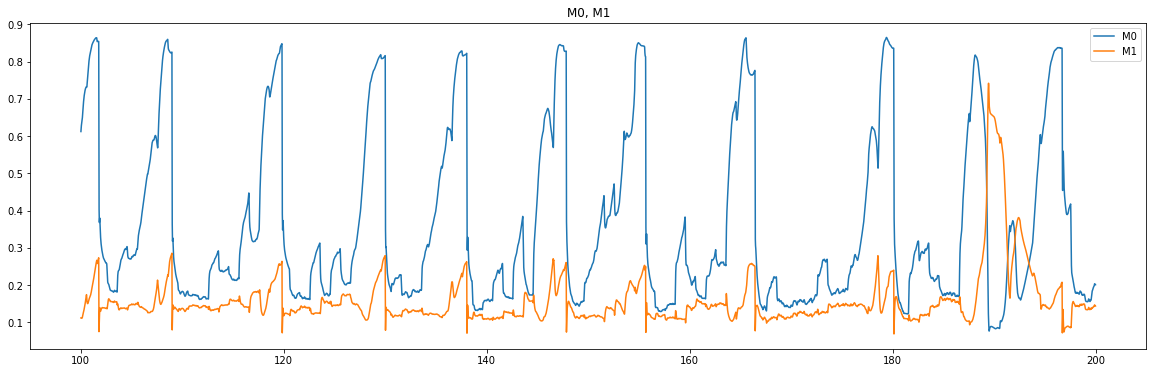

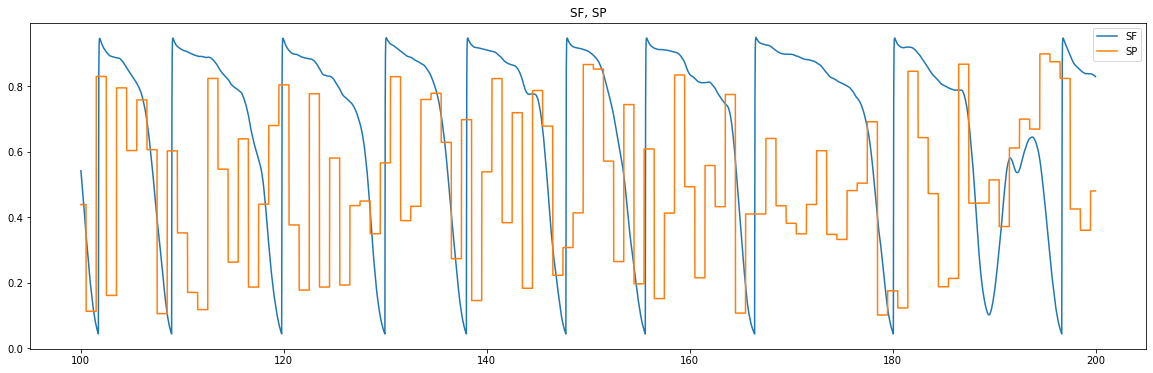

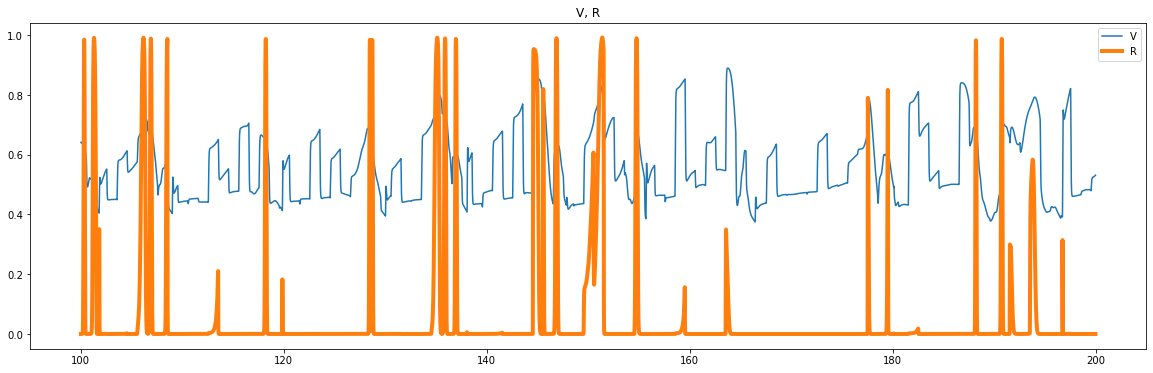

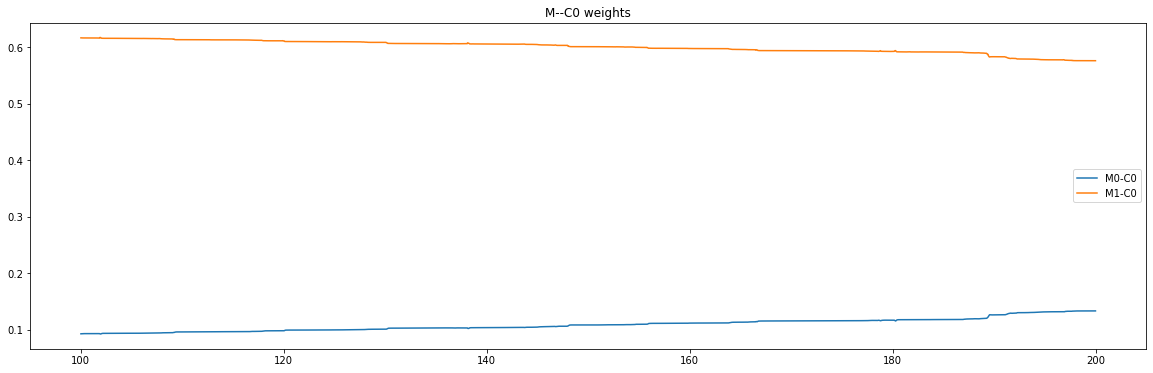

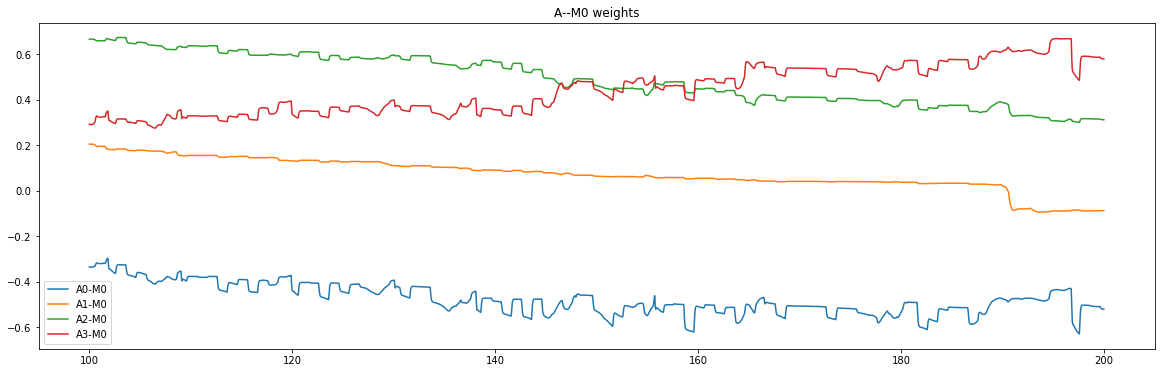

In [10]:
fs = (20,6)

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
plt.legend(['M0', 'M1'])
plt.title('M0, M1')
#print(M_data[:,-1])

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='SF')
plt.plot(times, SP_data.transpose(), label='SP')
plt.legend()
plt.title('SF, SP')
plt.show()
#print('SF = [%f]' % (SF_data[0,-1]))
#print('SP = [%f]' % (SP_data[0,-1]))

# V, R
V_fig = plt.figure(figsize=fs)
V_data = np.array(data[V])
plt.plot(times, V_data.transpose())
#plt.legend(['V'])
plt.title('V, R')
R_data = np.array(data[R])
plt.plot(times, R_data.transpose(), linewidth=4)
plt.legend(['V', 'R'])

# M--C0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_C0_track])
plt.plot(times, w_track_data.transpose())
plt.legend(['M0-C0', 'M1-C0'])
plt.title('M--C0 weights')

# A--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[A_M0_track])
plt.plot(times, w_track_data2.transpose())
plt.legend(['A0-M0', 'A1-M0', 'A2-M0', 'A3-M0'])
plt.title('A--M0 weights')

plt.show()

Text(0.5, 1.0, 'C1')

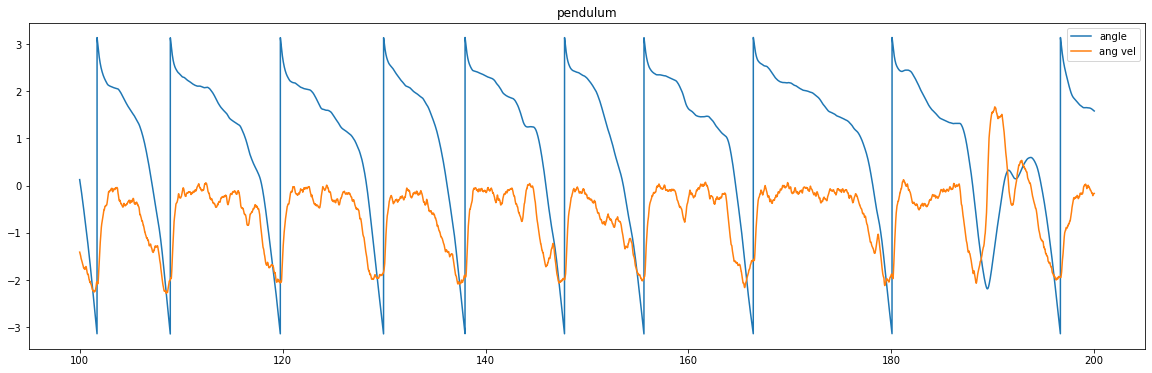

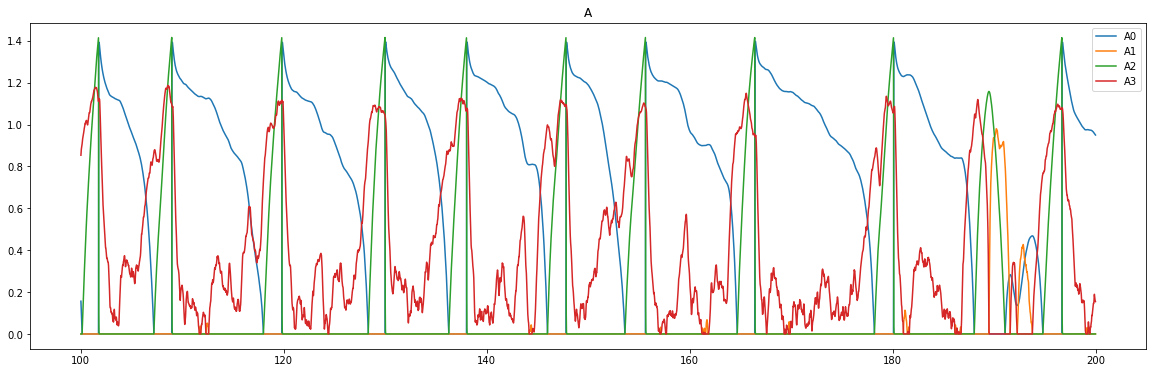

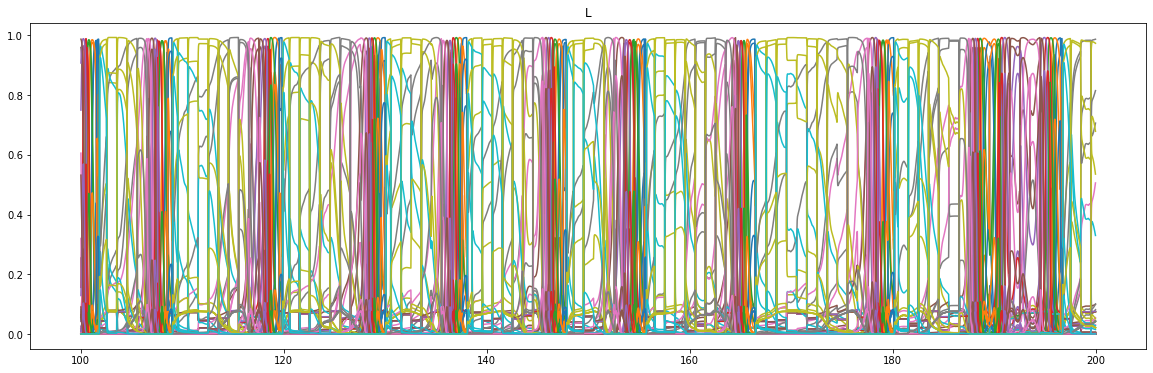

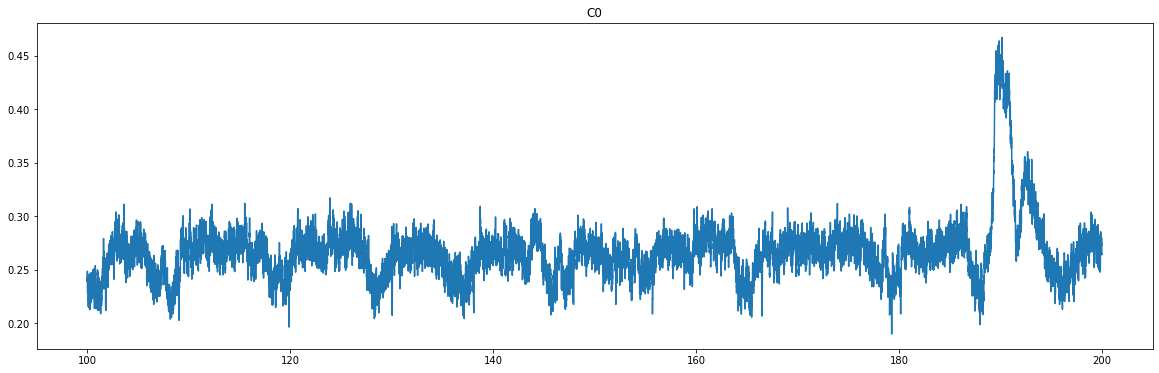

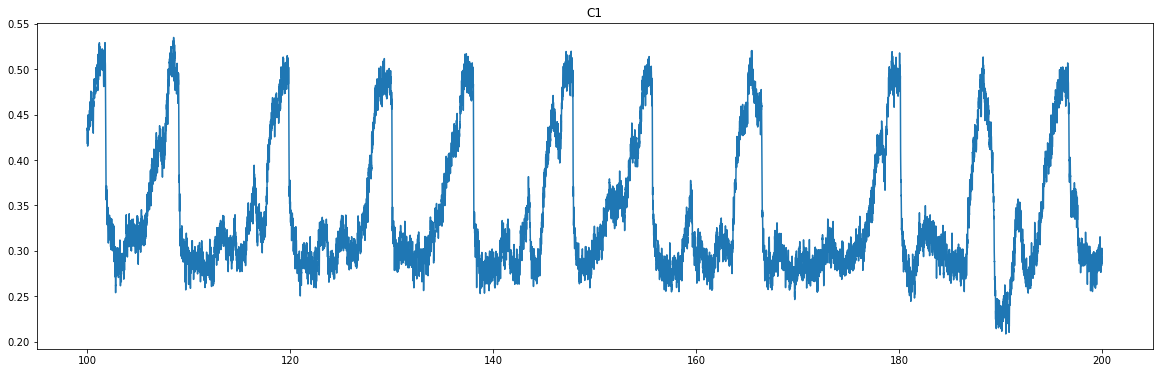

In [11]:
# P
P_fig = plt.figure(figsize=fs)
P_data = plant_data[P]
plt.plot(times, P_data[:,0], label='angle')
plt.plot(times, P_data[:,1], label='ang vel')
plt.legend()
plt.title('pendulum')
#print("angle: %f, vel: %f" % (P_data[-1,0],P_data[-1,1]))

# A
A_fig = plt.figure(figsize=fs)
A_data = np.array(data[A])
plt.plot(times, A_data.transpose())
plt.legend(['A0', 'A1', 'A2', 'A3'])
plt.title('A')
#print(A_data[:,-1])

# L
L_fig = plt.figure(figsize=fs)
L_data = np.array(data[L])
plt.plot(times, L_data.transpose())
plt.title('L')

# C0
C0_fig = plt.figure(figsize=fs)
C0_data = np.array(data[C[0]])
plt.plot(times, C0_data.transpose())
#plt.plot(times, data[dc_track[0]], linewidth=3)
plt.title('C0')
#print(C0_data[-1])

# C1
C1_fig = plt.figure(figsize=fs)
C1_data = np.array(data[C[1]])
plt.plot(times, C1_data.transpose())
#plt.plot(times, data[dc_track[1]], linewidth=3)
plt.title('C1')
#print(C1_data[-1])


In [7]:
plotty = plotter(net, times, data)

In [12]:
plotty.act_anim(S1+S2+L+R+V, 0.5, interv=10, slider=False)

In [8]:
plotty.conn_anim(L, V)

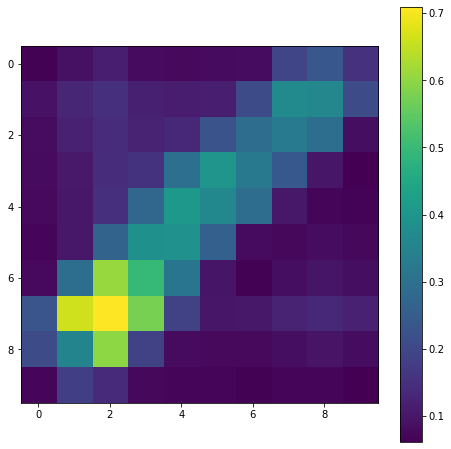

In [12]:
L__M_w_mat = np.zeros((No2, No2))
for i in range(No2):
    for j in range(No2):
        w = net.syns[V[0]][i*No2 + j].w
        #print("%.2f" % (w), end=' ')
        L__M_w_mat[i,No2-j-1] = w
    #print("\n")
    
L__M_w_mat_fig = plt.figure(figsize=(8,8))
axs = plt.subplot(1,1,1)
cs = axs.imshow(L__M_w_mat)
L__M_w_mat_fig.colorbar(cs)
plt.show()

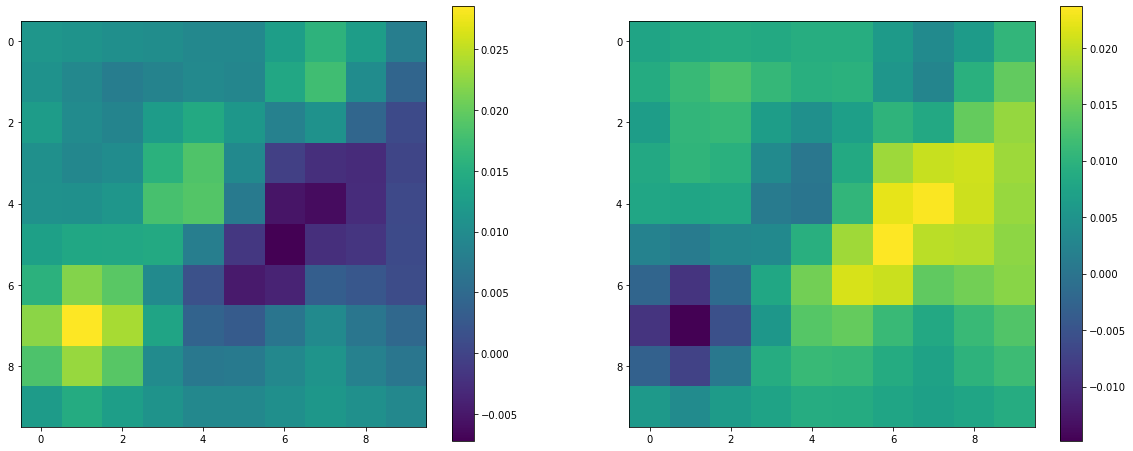

In [13]:
matty0 = np.zeros((No2, No2))
matty1 = np.zeros((No2, No2))
for i in range(No2):
    for j in range(No2):
        w0 = net.syns[M[0]][i*No2 + j+4].w
        w1 = net.syns[M[1]][i*No2 + j+4].w
        #print("%.2f" % (w), end=' ')
        matty0[i,No2-j-1] = w0
        matty1[i,No2-j-1] = w1
    #print("\n")
    
matty_fig = plt.figure(figsize=(20,8))
axs0 = plt.subplot(1,2,1)
cs0 = axs0.imshow(matty0)
plt.colorbar(cs0)
axs1 = plt.subplot(1,2,2)
cs1 = axs1.imshow(matty1)
plt.colorbar(cs1)
plt.show()

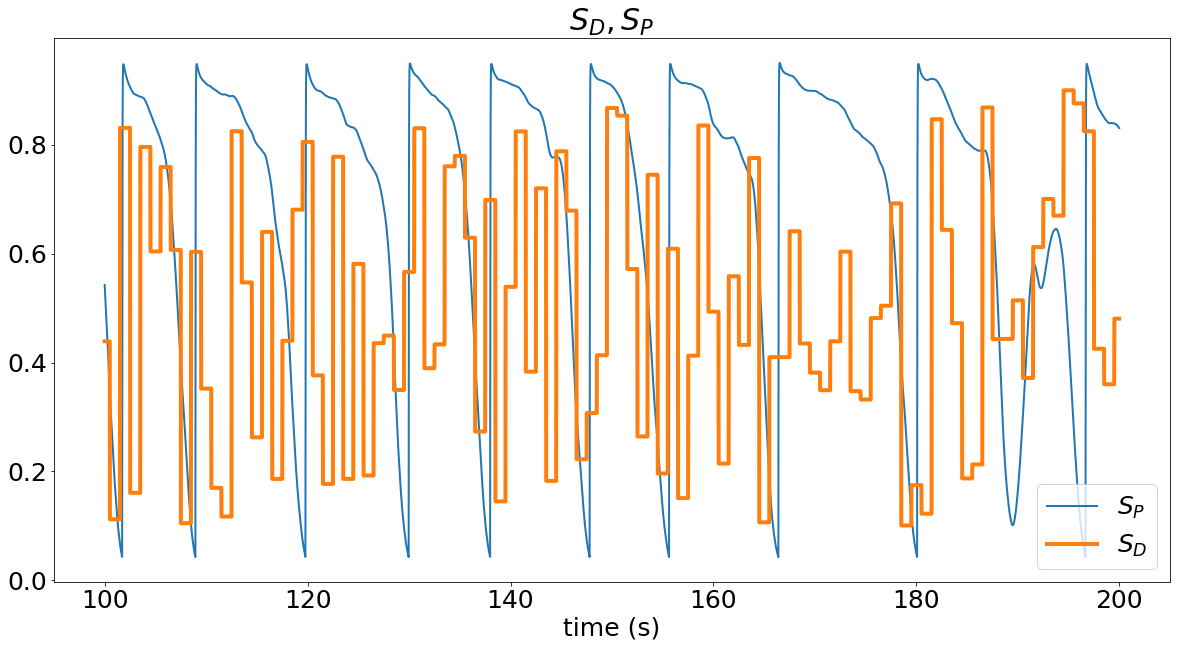

In [14]:
# A figure with more formatting
SPF_fig = plt.figure(figsize=(20,10))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='$S_P$', linewidth=2)
plt.plot(times, SP_data.transpose(), label='$S_D$', linewidth=4)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.xlabel('time (s)', fontsize =25)
plt.title('$S_D, S_P$', fontsize=30)
plt.show()

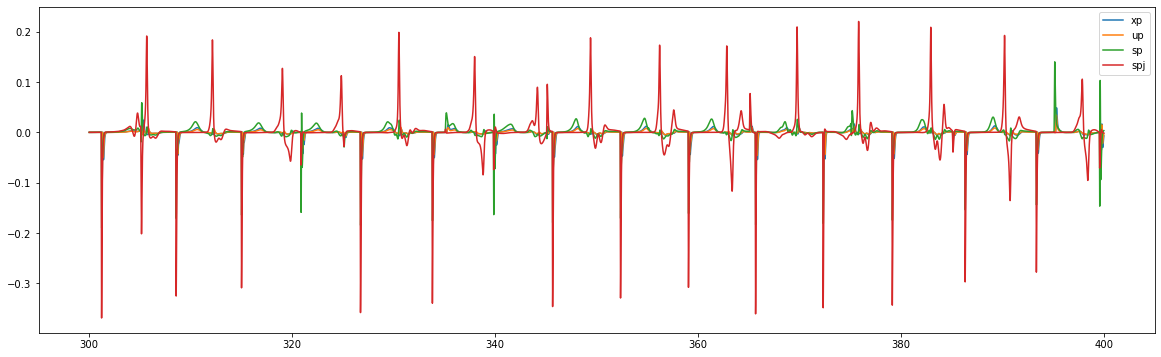

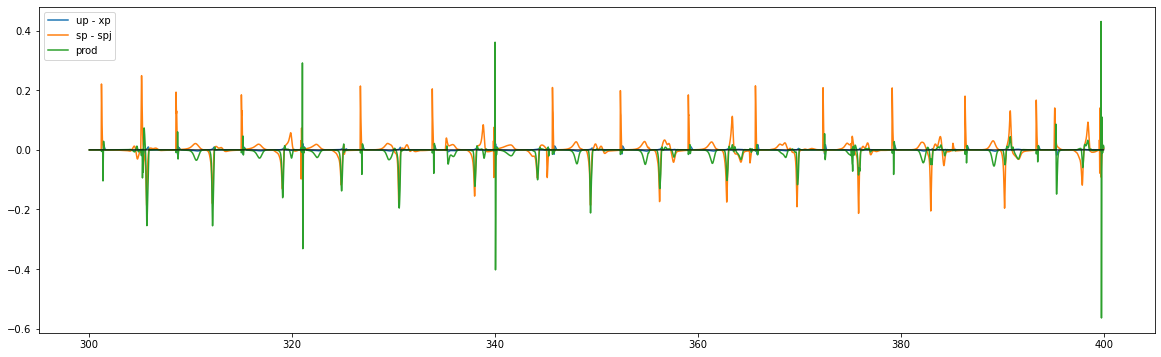

In [24]:
# plot all factors in the M--C0 synaptic plasticity
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

In [21]:
# checking some connections
print("Connections to motor units")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in L:
        pre_pop = 'L'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in V:
        pre_pop = 'V'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to C units")
for idx, syn in enumerate(net.syns[C[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

    
    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[A[2]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

    
print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))

Connections to motor units
0) A (0) --> M, w=0.352686, port=2, plant_out=None
1) A (1) --> M, w=0.428791, port=2, plant_out=None
2) A (2) --> M, w=0.323769, port=2, plant_out=None
3) A (3) --> M, w=0.394755, port=2, plant_out=None
4) L (6) --> M, w=0.008398, port=0, plant_out=None
5) L (7) --> M, w=0.010503, port=0, plant_out=None
6) L (8) --> M, w=0.009241, port=0, plant_out=None
7) L (9) --> M, w=0.013462, port=0, plant_out=None
8) L (10) --> M, w=0.029283, port=0, plant_out=None
9) L (11) --> M, w=0.025787, port=0, plant_out=None
10) L (12) --> M, w=0.009996, port=0, plant_out=None
11) L (13) --> M, w=0.005785, port=0, plant_out=None
12) L (14) --> M, w=0.003997, port=0, plant_out=None
13) L (15) --> M, w=0.004503, port=0, plant_out=None
14) L (16) --> M, w=0.010765, port=0, plant_out=None
15) L (17) --> M, w=0.012651, port=0, plant_out=None
16) L (18) --> M, w=0.012667, port=0, plant_out=None
17) L (19) --> M, w=0.019837, port=0, plant_out=None
18) L (20) --> M, w=0.032183, port=0,

---